In [3]:
# Imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.api as sm

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error

In [114]:
# Load
PATH = "insurance.csv"  
df = pd.read_csv(PATH)

print(df.head())
print(df.info())
print(df.describe().T)


   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None
           count          mean           std        min         25%       50%  \
age       

In [115]:
# Basic Cleaning

# 공백 제거, 소문자 통일 -> 있을 경우에 진행
for col in ["sex", "smoker", "region"]:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip().str.lower()

# 중복 확인
dups = df.duplicated().sum()
print(f"\n[중복 행 수] {dups}")

# 중복 제거
df = df.drop_duplicates() # 첫번째 행만 남기고 이후 중복

# 제거 한 뒤에 다시 확인
dups = df.duplicated().sum()
print(f"\n[제거 후 중복 행 수] {dups}")

# 결측치 확인
print("\n[결측치 개수]")
print(df.isna().sum())

# 간단 파생: 비만 여부 (CDC 기준 대략 BMI>=30)
df["obese"] = (df["bmi"] >= 30).astype(int)

# 타깃 로그변환(왜도 완화용)
df["charges_log"] = np.log1p(df["charges"])


[중복 행 수] 1

[제거 후 중복 행 수] 0

[결측치 개수]
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


## 파생변수 만든 이유?
- 원래 bmi는 연속형이지만, "비만 여부"라는 이진 변수로 바꾸면 해석이 쉬움 -> “비만자는 평균 보험료가 얼마 더 높은가?”
- 의료·보험에서는 BMI 30을 기준으로 고비만 여부를 나눔 (CDC, WHO 기준)

<Axes: >

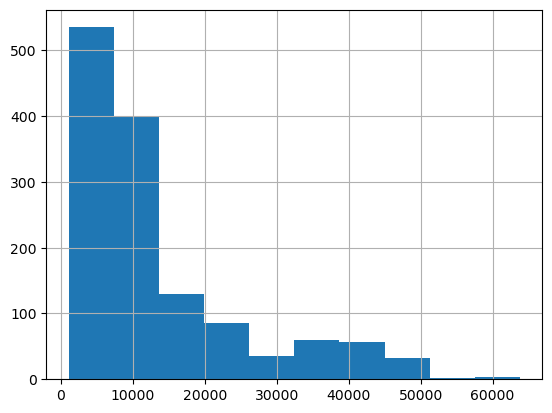

In [117]:
df["charges"].hist()

<Axes: >

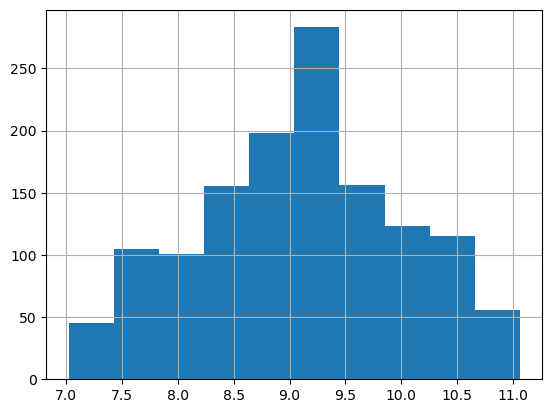

In [118]:
df["charges_log"].hist()

In [128]:
df

,age,sex,bmi,children,smoker,region,charges,obese,charges_log
0,19,female,27.900,0,yes,southwest,16884.92400,0,9.734236
1,18,male,33.770,1,no,southeast,1725.55230,1,7.453882
2,28,male,33.000,3,no,southeast,4449.46200,1,8.400763
3,33,male,22.705,0,no,northwest,21984.47061,0,9.998137
4,32,male,28.880,0,no,northwest,3866.85520,0,8.260455
...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,1,9.268755
1334,18,female,31.920,0,no,northeast,2205.98080,1,7.699381
1335,18,female,36.850,0,no,southeast,1629.83350,1,7.396847
1336,21,female,25.800,0,no,southwest,2007.94500,0,7.605365


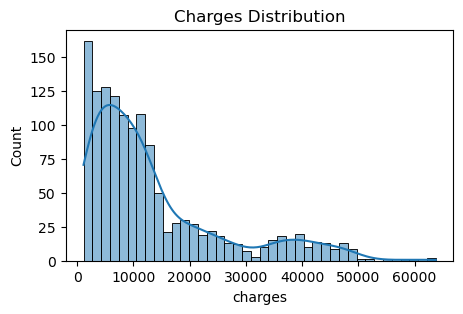

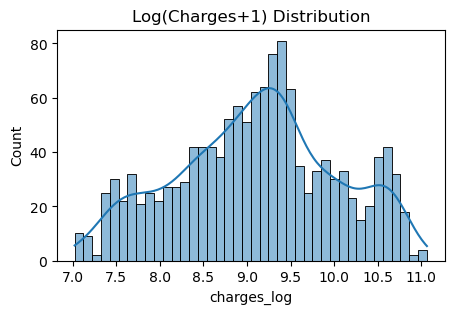

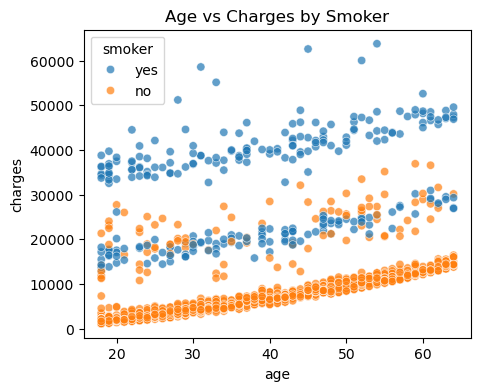

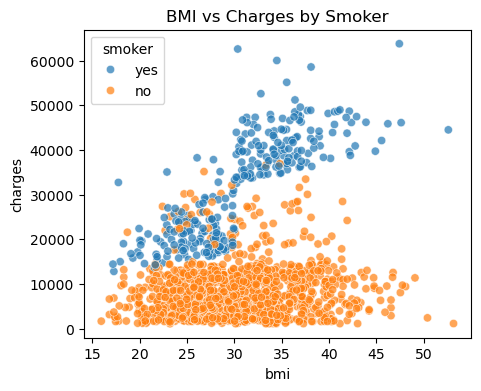

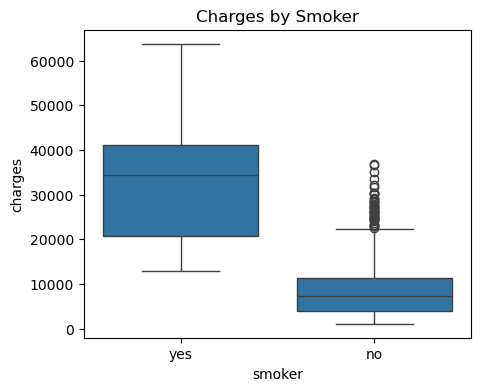

In [65]:
# Quick EDA
plt.figure(figsize=(5,3))
sns.histplot(df["charges"], bins=40, kde=True)
plt.title("Charges Distribution")
plt.show()

plt.figure(figsize=(5,3))
sns.histplot(df["charges_log"], bins=40, kde=True)
plt.title("Log(Charges+1) Distribution")
plt.show()

# 이변량 시각화
plt.figure(figsize=(5,4))
sns.scatterplot(data=df, x="age", y="charges", hue="smoker", alpha=0.7)
plt.title("Age vs Charges by Smoker")
plt.show()

plt.figure(figsize=(5,4))
sns.scatterplot(data=df, x="bmi", y="charges", hue="smoker", alpha=0.7)
plt.title("BMI vs Charges by Smoker")
plt.show()

plt.figure(figsize=(5,4))
sns.boxplot(data=df, x="smoker", y="charges")
plt.title("Charges by Smoker")
plt.show()

## 해석

1. 보험료 분포 (Charges Distribution vs Log Charges)

- 원본 charges: 오른쪽 꼬리가 긴 우측 치우침(right-skewed) → 소수의 고객(특히 흡연자, 고령자 등)이 매우 높은 보험료를 내고 있음.

- 로그 변환 후 charges_log: 분포가 훨씬 대칭에 가까워짐. → 정규성 가정을 만족시키려는 변환이 유효했음을 보여줌.


2. Age vs Charges (흡연자 구분)

- 비흡연자(no): 나이가 많아질수록 보험료가 서서히 증가 → 완만한 선형 패턴.

- 흡연자(yes): 전반적으로 보험료가 훨씬 높고, 나이 증가와 함께 더 가파르게 증가.

- 두 그룹이 뚜렷하게 분리되어 있음. -> 가설검정에서 확인해봐야겠다


3. BMI vs Charges (흡연자 구분)

- 비흡연자: BMI가 올라가도 보험료는 일정 수준 이하에서 크게 벗어나지 않음.

- 흡연자: BMI가 높을수록 보험료가 급격히 증가하는 경향.

- BMI가 일정 수준 이상일 때, 흡연자의 보험료는 특히 폭발적으로 높음.

->  BMI 단독으로는 보험료 영향이 크지 않지만, 흡연 여부와 상호작용할 때 강력한 효과를 보인다.

4. Boxplot (Smoker vs Non-smoker)

- 흡연자: 중앙값이 3만 달러 이상, 분포가 넓고 상위 구간은 6만 달러까지 확장.

- 비흡연자: 중앙값이 1만 달러 이하, 분포가 좁음.

- 두 그룹의 차이가 극명하고, 흡연자가 훨씬 큰 변동성과 높은 평균을 보임.

-> 흡연 여부는 보험료 차이를 설명하는 가장 중요한 이산 변수이다.

In [126]:
# 통계적 비교 (t-test / ANOVA)
# 데이터 수가 적어서 엄격하게 정규성 지켜서 t-test 할 경우
smk_yes = df.loc[df["smoker"]=="yes", "charges_log"]
smk_no  = df.loc[df["smoker"]=="no",  "charges_log"]
tstat, pval = stats.ttest_ind(smk_yes, smk_no, equal_var=False)  # Welch
print(f"\n[T-test (smoker)] t={tstat:.3f}, p={pval:.3g}")


# 흡연자 vs 비흡연자 t-test -> 표본이 커서 정규성 검정 건너 뜀 ->
# 또한 흡연자의 평균, 분산이 비흡연자 보다 클것으로 예상 (등분산 깨짐) -> 굳이 등분산성 검정 진행 안하고 안전하게 웰치 t-test
smk_yes = df.loc[df["smoker"]=="yes", "charges"]
smk_no  = df.loc[df["smoker"]=="no",  "charges"]
tstat, pval = stats.ttest_ind(smk_yes, smk_no, equal_var=False)  # Welch
print(f"\n[T-test (smoker)] t={tstat:.3f}, p={pval:.3g}")

print("----"*10)

# region별 ANOVA
groups = [g["charges"].values for _, g in df.groupby("region")] # -> 해당 지역에서 보험료 컬럼만 뽑아서 numpy 배열로 변환
fstat, pval = stats.f_oneway(*groups)
print(f"[ANOVA (region)] F={fstat:.3f}, p={pval:.3g}")

print("----"*10)

# 상관: 연속형 위주
print("\n[연속형 상관(피어슨)]")
print(df[["age","bmi","children","charges"]].corr(numeric_only=True))


[T-test (smoker)] t=46.347, p=7.07e-234

[T-test (smoker)] t=32.742, p=6.26e-103
----------------------------------------
[ANOVA (region)] F=2.926, p=0.0328
----------------------------------------

[연속형 상관(피어슨)]
               age       bmi  children   charges
age       1.000000  0.109344  0.041536  0.298308
bmi       0.109344  1.000000  0.012755  0.198401
children  0.041536  0.012755  1.000000  0.067389
charges   0.298308  0.198401  0.067389  1.000000


## 해석

### t-test
- p-value ≈ 0 → 귀무가설(“흡연자와 비흡연자의 보험료 평균은 같다”) 기각

- 즉, 흡연자의 보험료 평균이 비흡연자보다 유의하게 높다는 결론

- t 값이 32.7로 매우 크기 때문에 차이가 극적으로 크다는 걸 의미

-> 즉, 흡연 여부가 보험료에 큰 영향을 미친다.


### ANOVA
- p=0.03 < 0.05 → 지역 간 평균 보험료에 차이가 통계적으로 유의하다.

- 하지만 F값이 크지 않으므로, 지역 차이는 존재하더라도 흡연 여부에 비해 영향력이 약함.

-> 즉, 지역별로 보험료에 유의한 차이가 있긴 하지만, 그 효과는 크지 않다.

### 상관분석
- age와 charges: 약한 양의 상관(0.3 정도) → 나이가 많을수록 보험료가 조금 증가

- bmi와 charges: 약한 양의 상관(0.2) → BMI가 높을수록 보험료도 다소 증가

- children과 charges: 거의 무관(0.07) → 자녀 수는 보험료와 큰 관련 없음

-> 보험료에 영향을 주는 주요 요인은 나이와 BMI, 하지만 상관만 놓고 보면 효과는 제한적.(변수 하나만 놓고 봤을 때는)
-> children 변수가 age, bmi 같은 다른 변수와 결합할 때 의미가 생길 수도 있기에 일단 회귀에는 넣어서 진행하는 걸로

In [94]:
# Train/Test Split & Feature Spec

target_raw = "charges"
target_log = "charges_log"

y_raw = df[target_raw].values
y_log = df[target_log].values

num_cols = ["age", "bmi", "children"]
bin_cols = ["obese"]
cat_cols = ["sex", "smoker", "region"]

X = df[num_cols + bin_cols + cat_cols]

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X, y_raw, test_size=0.2, random_state=42, stratify=df["smoker"]
)

X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42, stratify=df["smoker"]
)

In [95]:
# ColumnTransformer (OneHot + Scale)
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("bin", "passthrough", bin_cols), # 그대로 둔다
        ("cat", OneHotEncoder(drop="first"), cat_cols),
    ],
    remainder="drop"
)

In [127]:
preprocess

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['age', 'bmi', 'children']),
                                ('bin', 'passthrough', ['obese']),
                                ('cat', OneHotEncoder(drop='first'),
                                 ['sex', 'smoker', 'region'])])

In [96]:
# Baseline Linear Regression (raw target)
linreg_raw = Pipeline(steps=[
    ("prep", preprocess),
    ("mdl", LinearRegression())
])

In [97]:
linreg_raw.fit(X_train_raw, y_train_raw)
pred_raw = linreg_raw.predict(X_test_raw)

print("\n[LinearRegression on RAW target]")
print(f"R2  : {r2_score(y_test_raw, pred_raw):.3f}")
print(f"RMSE: {root_mean_squared_error(y_test_raw, pred_raw):.2f}")
print(f"MAE : {mean_absolute_error(y_test_raw, pred_raw):.2f}")


[LinearRegression on RAW target]
R2  : 0.790
RMSE: 5561.55
MAE : 3934.94


In [98]:
linreg_raw[1].coef_

array([ 3644.03558749,   719.61242995,   602.54815848,  3061.49314017,
        -265.3383631 , 23898.92255339,  -539.44460204, -1098.51890695,
        -821.44087212])

In [99]:
linreg_raw[1].intercept_

7504.769301451462

In [130]:
def get_feature_names(preprocessor: ColumnTransformer):
    """ColumnTransformer 출력 피처명 복원"""
    names = []
    for name, trans, cols in preprocessor.transformers_:
        if name == "remainder" and trans == "drop":
            continue
        if hasattr(trans, "get_feature_names_out"):
            # OneHotEncoder, PolynomialFeatures 등
            try:
                if isinstance(cols, list):
                    base_names = cols
                else:
                    base_names = preprocessor.feature_names_in_[cols]
                out = trans.get_feature_names_out(base_names)
            except:
                out = trans.get_feature_names_out()
            names.extend(out)
        else:
            # passthrough
            if isinstance(cols, list):
                names.extend(cols)
            else:
                names.extend(preprocessor.feature_names_in_[cols])
    return names

def coef_table(pipe: Pipeline):
    prep = pipe.named_steps["prep"]
    mdl = pipe.named_steps["mdl"]
    feat_names = get_feature_names(prep)
    coefs = getattr(mdl, "coef_", None)
    if coefs is None:
        return None
    if coefs.ndim > 1:
        coefs = coefs.ravel()
    return pd.DataFrame({"feature": feat_names, "coef": coefs}).sort_values("coef", key=abs, ascending=False)

print("\n[계수 해석: Raw LinearRegression]")
print(coef_table(linreg_raw).head(12))


[계수 해석: Raw LinearRegression]
            feature          coef
5        smoker_yes  23898.922553
0               age   3644.035587
3             obese   3061.493140
7  region_southeast  -1098.518907
8  region_southwest   -821.440872
1               bmi    719.612430
2          children    602.548158
6  region_northwest   -539.444602
4          sex_male   -265.338363


In [131]:
coef_table(linreg_raw)

,feature,coef
5,smoker_yes,23898.922553
0,age,3644.035587
3,obese,3061.493140
7,region_southeast,-1098.518907
8,region_southwest,-821.440872
1,bmi,719.612430
2,children,602.548158
6,region_northwest,-539.444602
4,sex_male,-265.338363


## 해석

- 보험료에 가장 큰 영향을 미치는 변수는 흡연 여부 → 절대적 차이를 만들어냄

- 그다음으로 나이, 비만 여부, BMI가 꾸준히 증가 요인

- 자녀 수(children)는 상대적 영향이 작지만, 보험료를 소폭 늘림

- 지역(region)은 동북 대비 다른 지역은 평균적으로 조금 낮음

- 성별(sex)은 사실상 보험료에 큰 영향을 주지 않음

In [71]:
# Linear Regression on LOG target (exponentiate back)

linreg_log = Pipeline(steps=[
    ("prep", preprocess),
    ("mdl", LinearRegression())
])
linreg_log.fit(X_train_log, y_train_log)
pred_log_test = linreg_log.predict(X_test_log)

In [72]:
# 로그 예측 → 원 스케일로 변환: expm1
pred_log_back = np.expm1(pred_log_test)

print("\n[LinearRegression on LOG target]")
print(f"R2  : {r2_score(y_test_raw, pred_log_back):.3f}")
print(f"RMSE: {root_mean_squared_error(y_test_raw, pred_log_back):.2f}")
print(f"MAE : {mean_absolute_error(y_test_raw, pred_log_back):.2f}")


[LinearRegression on LOG target]
R2  : 0.531
RMSE: 8320.82
MAE : 4270.02
